In [ ]:
# 구글 드라이브 연동
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import os
import random
# from tensorflow.keras.layers import Dense, Conv2D, Dropout, Conv2DTranspose, MaxPooling2D, BatchNormalization, Activation, concatenate, Input, GlobalAveragePooling2D
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import zipfile
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
# from keras.models import Model,load_model
# from keras.layers import *
import keras


import warnings
 
warnings.filterwarnings("ignore")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [ ]:
# 재생산성을 위해 시드 고정
np.random.seed(7)
random.seed(7)
tf.random.set_seed(7)

In [ ]:
# 디렉토리 변경
os.chdir('drive/My Drive/Colab Notebooks/Dacon/AIFrenz_Season2/')

In [ ]:
files_name = glob.glob('./data/dacon_npy/*')
files_name

['./data/dacon_npy/train_data.npy',
 './data/dacon_npy/train_images.npy',
 './data/dacon_npy/test_data.npy',
 './data/dacon_npy/test_images.npy',
 './data/dacon_npy/train_labels.npy',
 './data/dacon_npy/train.npy',
 './data/dacon_npy/test.npy',
 './data/dacon_npy/onehot_train_data.npy',
 './data/dacon_npy/onehot_test_data.npy',
 './data/dacon_npy/test_refined.npy',
 './data/dacon_npy/train_refined.npy',
 './data/dacon_npy/full_train_diff.npy']

In [ ]:
# data 불러오기
# train = np.load('./data/dacon_npy/train_images.npy')
# data = np.load('./data/dacon_npy/train_data.npy')
# label = np.load('./data/dacon_npy/train_labels.npy')
label = np.load('./data/dacon_npy/train_labels.npy')

In [ ]:
# nan 개수 
nan_count=[]
for i in range(label.shape[0]):
  num = (label[i,:,:,-1]<0).sum()
  if num >0:
    nan_count.append((label[i,:,:,-1]<0).sum())

print(len(nan_count), sum(nan_count))

388 543756


100%|██████████| 76345/76345 [00:00<00:00, 77276.92it/s]


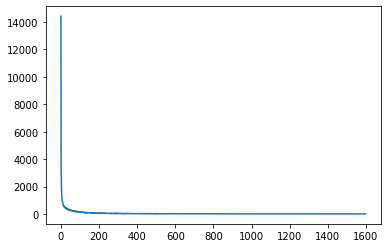

In [ ]:
# 강수량 있는 픽셀 개수 세기
count=[]
for i in tqdm(label):
  # print((i>0).sum())
  count.append((i>0).sum())

df = pd.DataFrame(count,columns=['num'])
df['num'].value_counts().sort_index().plot()

In [ ]:
df['num'].value_counts().sort_index()#[:50].sum()

0       14421
1        3647
2        2354
3        1705
4        1455
        ...  
1580        2
1583        1
1585        1
1589        1
1597        1
Name: num, Length: 1347, dtype: int64

In [ ]:
df['num'].value_counts().sort_index()[49:].sum() / df['num'].value_counts().sum(), df['num'].value_counts().sort_index()[49:].sum() 

(0.4062479533695723, 31015)

In [ ]:
# nan 있는거 제거
# 강수량 픽셀 n개 이하 제거
num=[]
n = 50
for i in range(label.shape[0]):
  if ((label[i]>0).sum() >= n):# and ((label[i]<0).sum() <= 0):
    num.append(i)

len(num) / label.shape[0]
len(num)

30760

In [ ]:
len(num)

75957

In [ ]:
train = train[num]
data = data[num]
label = label[num]

In [ ]:
train.shape, label.shape

((30465, 40, 40, 9), (30465, 40, 40, 1))

In [ ]:
train = np.concatenate((train, label),axis=3)
del label

In [ ]:
img_datagen = ImageDataGenerator(rotation_range=60,
                                 width_shift_range=0.4,
                                 height_shift_range=0.4)

genTrain = img_datagen.flow(train, batch_size=train.shape[0], shuffle=True)[0]
genTrain2 = img_datagen.flow(train, batch_size=train.shape[0], shuffle=True)[0]
genTrain3 = img_datagen.flow(train, batch_size=train.shape[0], shuffle=True)[0]

In [ ]:
genTrain = genTrain[:int(genTrain.shape[0]/2),:,:,:]
gen = np.concatenate((genTrain, genTrain2), axis=0)
del genTrain
del genTrain2
del genTrain3

In [ ]:
train = np.concatenate((train, gen),axis=0)
del gen

In [ ]:
label = train[:,:,:,-1:]
train = train[:,:,:,:9]

In [ ]:
for i in tqdm(range(train_data.shape[0])):
  train_sub = np.concatenate((np.where((train_data[i]<100), 1,0).reshape(1,40,40,-1),
                                  np.where((train_data[i]>=100)&(train_data[i]<200), 1,0).reshape(1,40,40,-1),
                                  np.where((train_data[i]>=200)&(train_data[i]<300), 1,0).reshape(1,40,40,-1),
                                  np.where((train_data[i]>=300), 1,0).reshape(1,40,40,-1),
                                  train_data[i].reshape(1,40,40,-1)), axis=3)
  if i==0:
    train_onehot = train_sub
  else:
    train_onehot = np.concatenate((train_onehot, train_sub), axis=0)

np.save("onehot_train_data.npy",train_onehot)

100%|██████████| 41138/41138 [4:29:56<00:00,  2.54it/s]


In [ ]:
for i in tqdm(range(test_data.shape[0])):
  test_sub = np.concatenate((np.where((test_data[i]<100), 1,0).reshape(1,40,40,-1),
                                  np.where((test_data[i]>=100)&(test_data[i]<200), 1,0).reshape(1,40,40,-1),
                                  np.where((test_data[i]>=200)&(test_data[i]<300), 1,0).reshape(1,40,40,-1),
                                  np.where((test_data[i]>=300), 1,0).reshape(1,40,40,-1),
                                  test_data[i].reshape(1,40,40,-1)), axis=3)
  if i==0:
    test_onehot = test_sub
  else:
    test_onehot = np.concatenate((test_onehot, test_sub), axis=0)

np.save("onehot_test_data.npy",test_onehot)

100%|██████████| 2416/2416 [01:07<00:00, 35.85it/s]


In [ ]:
train_onehot.shape

(1, 40, 40, 205690)

In [ ]:
train_img.shape, label.shape

((41138, 40, 40, 9), (41138, 40, 40, 1))

In [ ]:
# train  7:3으로 나누기
values = list(range(train.shape[0]))
train_num, test_num = train_test_split(values, test_size=0.3)

len(train_num)/train.shape[0], len(test_num)/train.shape[0]

(0.6999947480370788, 0.30000525196292116)

In [ ]:
xTest = train[test_num]
yTest = label[test_num]
train = train[train_num]
label = label[train_num]

train.shape, label.shape, xTest.shape, yTest.shape

((53313, 40, 40, 9),
 (53313, 40, 40, 1),
 (22849, 40, 40, 9),
 (22849, 40, 40, 1))

In [ ]:
def build_model(input_layer, start_neurons):
    
    # 40 x 40 -> 20 x 20
    conv1 = Conv2D(start_neurons * 6, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 6, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D((2, 2))(pool1)
    pool1 = Dropout(0.25)(pool1)

    # 20 x 20 -> 10 x 10
    conv2 = Conv2D(start_neurons * 5, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 5, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D( (2, 2))(pool2)
    pool2 = Dropout(0.25)(pool2)

    # 10 x 10 
    convm = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)

    # 10 x 10 -> 20 x 20
    deconv2 = Conv2DTranspose(start_neurons * 3, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.25)(uconv2)
    uconv2 = Conv2D(start_neurons * 3, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 3, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = BatchNormalization()(uconv2)

    # 20 x 20 -> 40 x 40
    deconv1 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.25)(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = BatchNormalization()(uconv1)

    uconv1 = Dropout(0.25)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation='relu')(uconv1)
    
    return output_layer

input_layer = Input((40, 40, 9))
output_layer = build_model(input_layer, 32)

In [ ]:
model = Model(input_layer, output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40, 40, 9)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 40, 40, 192)  15744       input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 40, 192)  331968      conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 40, 40, 192)  768         conv2d_1[0][0]                   
______________________________________________________________________________________________

In [ ]:
from sklearn.metrics import f1_score

def mae(y_true, y_pred) :
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    over_threshold = y_true >= 0.1
    
    return np.mean(np.abs(y_true[over_threshold] - y_pred[over_threshold]))

def fscore(y_true, y_pred):
    
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    y_true = y_true.reshape(1, -1)[0]
    
    y_pred = y_pred.reshape(1, -1)[0]
    
    remove_NAs = y_true >= 0
    
    y_true = np.where(y_true[remove_NAs] >= 0.1, 1, 0)
    
    y_pred = np.where(y_pred[remove_NAs] >= 0.1, 1, 0)
    
    return(f1_score(y_true, y_pred))

def maeOverFscore(y_true, y_pred):
    
    return mae(y_true, y_pred) / (fscore(y_true, y_pred) + 1e-07)

def fscore_keras(y_true, y_pred):
    score = tf.py_function(func=fscore, inp=[y_true, y_pred], Tout=tf.float32, name='fscore_keras')
    return score

def maeOverFscore_keras(y_true, y_pred):
    score = tf.py_function(func=maeOverFscore, inp=[y_true, y_pred], Tout=tf.float32,  name='custom_mse') 
    return score

In [ ]:
# modelPath="./Model/{epoch:02d}-{val_loss:.4f}.hdf5"
# checkpoint = ModelCheckpoint(filepath = modelPath, monitor='val_loss', verbose=1,save_best_only=True)
earlystopping = EarlyStopping(patience=5)

In [ ]:
model.compile(loss="mae", optimizer="adam", metrics=[maeOverFscore_keras, fscore_keras])

In [ ]:
# ###
# train = train[:,:,:,[2,3,4,5,6]]
# xTest = xTest[:,:,:,[2,3,4,5,6]]


# train.shape, label.shape, xTest.shape, yTest.shape

((42651, 40, 40, 5),
 (42651, 40, 40, 1),
 (18279, 40, 40, 5),
 (18279, 40, 40, 1))

In [ ]:
model_history = model.fit(train, label,
                          epochs = 50, batch_size=256, verbose=1,
                          validation_data=(xTest, yTest),
                          callbacks=[earlystopping])

Epoch 1/50
209/209 [==============================] - 208s 994ms/step - loss: 0.3186 - maeOverFscore_keras: 3.4414 - fscore_keras: 0.5213 - val_loss: 0.3030 - val_maeOverFscore_keras: 4.3855 - val_fscore_keras: 0.3826
Epoch 2/50
209/209 [==============================] - 205s 983ms/step - loss: 0.2582 - maeOverFscore_keras: 2.2198 - fscore_keras: 0.6260 - val_loss: 0.2610 - val_maeOverFscore_keras: 2.7159 - val_fscore_keras: 0.5255
Epoch 3/50
209/209 [==============================] - 207s 990ms/step - loss: 0.2476 - maeOverFscore_keras: 2.0183 - fscore_keras: 0.6597 - val_loss: 0.2664 - val_maeOverFscore_keras: 3.0183 - val_fscore_keras: 0.4858
Epoch 4/50
209/209 [==============================] - 207s 993ms/step - loss: 0.2426 - maeOverFscore_keras: 1.9190 - fscore_keras: 0.6798 - val_loss: 0.2597 - val_maeOverFscore_keras: 2.6321 - val_fscore_keras: 0.5389
Epoch 5/50
 46/209 [=====>........................] - ETA: 2:07 - loss: 0.2449 - maeOverFscore_keras: 1.8878 - fscore_keras: 0.6

In [ ]:
test = np.load('./data/dacon_npy/test_images.npy')

In [ ]:
pred = model.predict(test)
submission = pd.read_csv('./data/sample_submission.csv')
submission.iloc[:,1:] = pred.reshape(-1, 1600)
submission.to_csv('./f1.csv', index = False)